### Transfer learning example

Data is taken from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
(You need an account for the data but Kaggle is good resource anyway)
Note the folder structure
```
train
->cat
->dog
```

(Yes I have multiple train directories)

In [2]:
import tensorflow as tf
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'G:/kaggle/catdog/dogs-vs-cats-redux-kernels-edition/train/train/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256, 256),
  batch_size=12)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'G:/kaggle/catdog/dogs-vs-cats-redux-kernels-edition/train/train/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256, 256),
  batch_size=12)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### Display Images
Because not all of the images are sqaure when we force the size to 256x256 some of them appear distorted.  This is fine. Note that the labels are infered from the folder name, but data is picked up 'at random'

['cat', 'dog']


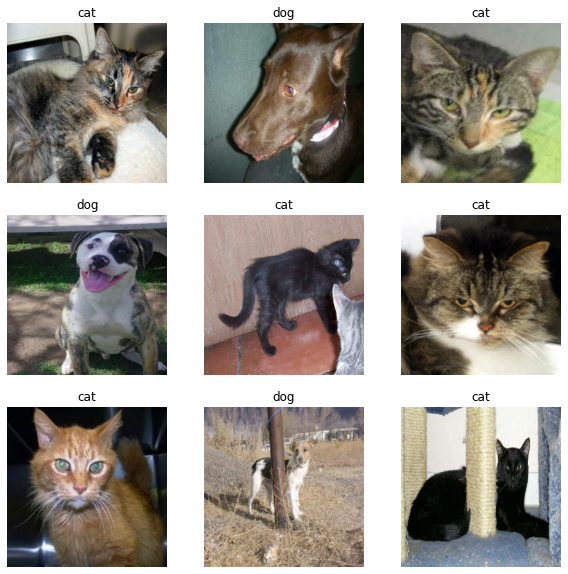

In [3]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Data Details
Most image data comes in values of 0 to 255, but of course neural networks like data between -1 and 1 or 0 and 1, so we adjust the values by divinding by the max value of 255 (including 0, thats 256 values!).  When we display the image it doesn't chaange much

Normalized Example
tf.Tensor(
[[0.5269991  0.5090993  0.50728106 0.55331653]
 [0.57555056 0.5701617  0.5642972  0.5893609 ]
 [0.59946686 0.6130362  0.611849   0.62816906]
 [0.60019916 0.6167747  0.6249924  0.6399595 ]], shape=(4, 4), dtype=float32)
Raw Example
(256, 256, 3)
tf.Tensor(
[[62.80237  64.94141  62.441406 68.135376]
 [67.292114 71.13733  70.08716  71.798584]
 [65.92554  70.28162  70.85742  68.994385]
 [69.57483  70.55078  72.911865 70.72656 ]], shape=(4, 4), dtype=float32)


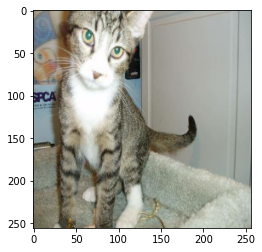

In [4]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
plt.imshow(first_image)
print('Normalized Example')
print(first_image[0:4,0:4,0])
new_batch, _ = next(iter(train_ds))
print('Raw Example')
print(new_batch[0].shape)
print(new_batch[0][0:4,0:4,0])



### Make a simple CNN from scartch

In [5]:
num_classes = 1

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='sigmoid')
])


In [6]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['binary_crossentropy','accuracy'])


In [7]:
model.fit(
  train_ds,     # note in class I switched this to the normalized_ds, but since I have rescaling at line 4 in the model, I use the train_ds!     
  epochs=5,
  validation_data=val_ds
)

Epoch 1/5
1667/1667 [==============================] - 144s 84ms/step - loss: 0.6699 - binary_crossentropy: 0.6699 - accuracy: 0.5894 - val_loss: 0.6093 - val_binary_crossentropy: 0.6093 - val_accuracy: 0.6776
Epoch 2/5
1667/1667 [==============================] - 112s 67ms/step - loss: 0.5478 - binary_crossentropy: 0.5478 - accuracy: 0.7231 - val_loss: 0.4983 - val_binary_crossentropy: 0.4983 - val_accuracy: 0.7580
Epoch 3/5
1667/1667 [==============================] - 65s 39ms/step - loss: 0.4290 - binary_crossentropy: 0.4290 - accuracy: 0.8026 - val_loss: 0.5521 - val_binary_crossentropy: 0.5521 - val_accuracy: 0.7632
Epoch 4/5
1667/1667 [==============================] - 56s 33ms/step - loss: 0.3076 - binary_crossentropy: 0.3076 - accuracy: 0.8667 - val_loss: 0.5906 - val_binary_crossentropy: 0.5906 - val_accuracy: 0.7688binary_crossentropy: 0.3078 - accuracy: 0.
Epoch 5/5
1667/1667 [==============================] - 58s 35ms/step - loss: 0.2032 - binary_crossentropy: 0.2032 - accu

### Transfer Models
Not content to use our own models, lets use some famous models.  Here I use EffcientNet, but you can do the same for models like ResNet, Inception, VGG16, etc.



In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np


### I will start from scractch with EfficientNetB0. 

I will not include pre-trained weights (`weights=None`) OR the final layers (`include_top=False`) before prediction.
I also 'allow' or set all of the layers to be trainable (you can pick and chose this btw).  The logs callback isn't nessecary, but nice to show what is going on.  Since I didn't include the final layers, I need to add my own.  Note that I am using the `Model()` api where I just chain together equations `x2 = GlobalAveragePooling2D()(x)` means the output is x2, and the input is x.

In [9]:
logs='example'
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
es = EarlyStopping()
# create the base pre-trained model
base_model = EfficientNetB0(weights=None, include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x2 = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x3 = Dense(1024, activation='relu')(x2)
# and a logistic layer 
predictions = Dense(1, activation='sigmoid')(x3)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = True

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy','accuracy'])

# train the model on the new data for a few epochs
model.fit(train_ds,
          epochs=5,
          validation_data=val_ds,
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir = logs)])



G:\QTW MSDS7333\notebooks\MSDS7333\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
1667/1667 [==============================] - 292s 167ms/step - loss: 0.6367 - binary_crossentropy: 0.6367 - accuracy: 0.6475 - val_loss: 0.5760 - val_binary_crossentropy: 0.5760 - val_accuracy: 0.6970
Epoch 2/5
1667/1667 [==============================] - 292s 175ms/step - loss: 0.4895 - binary_crossentropy: 0.4895 - accuracy: 0.7648 - val_loss: 0.4344 - val_binary_crossentropy: 0.4344 - val_accuracy: 0.7966
Epoch 3/5
1667/1667 [==============================] - 299s 179ms/step - loss: 0.3811 - binary_crossentropy: 0.3811 - accuracy: 0.8327 - val_loss: 0.3156 - val_binary_crossentropy: 0.3156 - val_accuracy: 0.8656
Epoch 4/5
1667/1667 [==============================] - 295s 177ms/step - loss: 0.3121 - binary_crossentropy: 0.3121 - accuracy: 0.8674 - val_loss: 0.4036 - val_binary_crossentropy: 0.4036 - val_accuracy: 0.8304
Epoch 5/5
1667/1667 [==============================] - 287s 172ms/step - loss: 0.2436 - binary_crossentropy: 0.2436 - accuracy: 0.9015 - val_loss: 0.2279 - 

### Transfer Learning
Now I will download the previously trained weights.  Notice I now use `weights='imagenet'` and set the base model to not be trainable with `layer.trainable = False`.  Even though I am freezing 99% of the network, I am allowsing my dense layer to recombine the features.  Look at how quickly this network acheives a super-high result. Also note that the network trains 5X faster (on my machine) since we are only training the last few layers!

USE TRANSFER LEARNING!

In [10]:
base_model = EfficientNetB0(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x2 = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x3 = Dense(1024, activation='relu')(x2)
# and a logistic layer 
predictions = Dense(1, activation='sigmoid')(x3)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy','accuracy'])

# train the model on the new data for a few epochs
model.fit(train_ds,
          epochs=5,
          validation_data=val_ds,
          callbacks=[tf.keras.callbacks.TensorBoard(log_dir = logs)])


Epoch 1/5
1667/1667 [==============================] - 101s 55ms/step - loss: 0.0352 - binary_crossentropy: 0.0352 - accuracy: 0.9876 - val_loss: 0.0334 - val_binary_crossentropy: 0.0334 - val_accuracy: 0.9888
Epoch 2/5
1667/1667 [==============================] - 86s 51ms/step - loss: 0.0228 - binary_crossentropy: 0.0228 - accuracy: 0.9925 - val_loss: 0.0280 - val_binary_crossentropy: 0.0280 - val_accuracy: 0.9914
Epoch 3/5
1667/1667 [==============================] - 87s 52ms/step - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.9950 - val_loss: 0.0342 - val_binary_crossentropy: 0.0342 - val_accuracy: 0.9912
Epoch 4/5
1667/1667 [==============================] - 88s 53ms/step - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.9949 - val_loss: 0.0501 - val_binary_crossentropy: 0.0501 - val_accuracy: 0.9906
Epoch 5/5
1667/1667 [==============================] - 91s 55ms/step - loss: 0.0105 - binary_crossentropy: 0.0105 - accuracy: 0.9965 - val_loss: 0.0613 - val_binar

base_model.summary()


You can see that the transfer learning was faster and more accurate than training from scratch, as well as much faster and more accurate than my 'basic' model.  1 epoch of Effcientnet took almost 5 minutes to train, while transfer learning with it, took 1.5 minutes per epoch and we ended with 99% accuracy after only 1 epoch!!  This was not even close to where we were after 5 epochs of our own!  Effcientnet is also one of the best performing (and largest--it is designed for scaling) networks!  So we can get to use an advanced network with just a few lines of code.